In [ ]:
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Flatten, UpSampling2D, Activation
from tensorflow.keras.layers import Layer, Dense, Input, Dropout, Conv2D, concatenate
from tensorflow.python.keras.layers.convolutional import Conv2DTranspose
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm.notebook import tqdm
from PIL import ImageOps
import tensorflow as tf
import numpy as np
import warnings
import datetime
import cv2 as cv
import PIL
import os


drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Mounted at /content/drive


## Entrenamiento del modelo

### Encoder

In [ ]:
class bloque_1(Layer):
  def __init__(self, num_kernels, kernel_tam, ker_reg= None):
    super(bloque_1, self).__init__()
    self.conv1= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    self.conv2= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    
    self.bn1= BatchNormalization()
    self.bn2= BatchNormalization()
    
    self.mp= MaxPooling2D(3, strides = 2, padding= "same")

  def call(self, entrada_tensor):
    x= self.conv1(entrada_tensor)
    x= self.bn1(x)
    x= self.conv2(x)
    x= self.bn2(x)

    return x, self.mp(x)


class bloque_2(Layer):
  def __init__(self, num_kernels, kernel_tam, ker_reg= None):
    super(bloque_2, self).__init__()
    self.conv1= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    self.conv2= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    self.conv3= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    
    self.bn1= BatchNormalization()
    self.bn2= BatchNormalization()
    self.bn3= BatchNormalization()
    
    self.mp= MaxPooling2D(3, strides = 2, padding= "same")

  def call(self, entrada_tensor):
    x= self.conv1(entrada_tensor)
    x= self.bn1(x)
    x= self.conv2(x)
    x= self.bn2(x)
    x= self.conv3(x)
    x= self.bn3(x)

    return x, self.mp(x)

### Decoder

In [ ]:
class up_conc(Layer):
  def __init__(self):
    super(up_conc, self).__init__()
    self.up_sampling= UpSampling2D(2)

  def call(self, entrada, res):
    x= self.up_sampling(entrada)
    return concatenate([x, res])

class conv_f(Layer):
  def __init__(self, num_kernels, kernel_tam, ker_reg= None):
    super(conv_f, self).__init__()
    self.conv1= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    self.conv2= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    self.conv3= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    
    self.bn1= BatchNormalization()
    self.bn2= BatchNormalization()
    self.bn3= BatchNormalization()

    self.trans= Conv2DTranspose(int(num_kernels/2),
                                kernel_size= kernel_tam, 
                                padding= 'same', activation= 'relu')

  def call(self, entrada):
    x= self.conv1(entrada)
    x= self.bn1(x)
    x= self.conv2(x)
    x= self.bn2(x)
    x= self.conv3(x)
    x= self.bn3(x)

    return self.trans(x)


class conv_v(Layer):
  def __init__(self, num_kernels, kernel_tam, ker_reg= None):
    super(conv_v, self).__init__()
    self.conv1= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    self.conv2= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    self.bn1= BatchNormalization()
    self.bn2= BatchNormalization()

    self.trans= Conv2DTranspose(int(num_kernels/2),
                                kernel_size= kernel_tam, 
                                padding= 'same', activation= 'relu')

  def call(self, entrada):
    x= self.conv1(entrada)
    x= self.bn1(x)
    x= self.conv2(x)
    x= self.bn2(x)

    return self.trans(x)


class salida_dec(Layer):
  def __init__(self, num_kernels, kernel_tam, salida, ker_reg= None):
    super(salida_dec, self).__init__()
    self.conv1= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    self.conv2= Conv2D(num_kernels, kernel_size= kernel_tam,
                      padding= "same", kernel_regularizer= ker_reg,
                      activation= "relu")
    
    self.bn1= BatchNormalization()
    self.bn2= BatchNormalization()
    self.convs= Conv2D(salida, kernel_tam, padding= "same", activation= "softmax")

  def call(self, entrada):
    x= self.conv1(entrada)
    x= self.bn1(x)
    x= self.conv2(x)
    x= self.bn2(x)
    
    return self.convs(x)

###Modulos de atención

In [ ]:
class CBAM(Layer):
  def __init__(self, num_kernels, ratio):
    super(CBAM, self).__init__()

    reduccion= int(num_kernels// ratio)
    self.davr_r= Dense(reduccion, activation= 'relu')
    self.dmax_r= Dense(reduccion, activation= 'relu')

    self.davr_a= Dense(num_kernels, activation= 'relu')
    self.dmax_a= Dense(num_kernels, activation= 'relu')

    self.act= Activation('sigmoid')
    self.act_1= Activation('sigmoid')

    self.conv= Conv2D(1, kernel_size= 7, padding= 'same')
    self.batch= BatchNormalization()

  def call(self, entrada):
    favr= tf.reduce_mean(entrada, axis= [-1], keepdims= True)
    fmax= tf.reduce_max(entrada, axis= [-1], keepdims= True)
    x_1= self.davr_r(favr)
    x_2= self.dmax_r(fmax)
    x= tf.add(self.davr_a(x_1), self.dmax_a(x_2))
    x= self.act(x)
    r= tf.math.multiply(entrada, x)

    favr_s= tf.reduce_mean(r, axis= [-1], keepdims= True)
    fmax_s= tf.reduce_max(r, axis= [-1], keepdims= True)
    r= tf.concat([favr_s, fmax_s], axis= -1)
    r= self.conv(r)
    r= self.batch(r)
    return self.act_1(r)

In [ ]:
class VGG_16(Model):
  def __init__(self, num_classes):
    super(VGG_16, self).__init__()

    # Atencion encoder
    self.att1= CBAM(64, 16)
    self.att2= CBAM(128, 16)
    self.att3= CBAM(256, 16)
    self.att4= CBAM(512, 16)
    self.att5= CBAM(512, 16)

    # Atencion decoder
    self.dtt1= CBAM(512, 16)
    self.dtt2= CBAM(512, 16)
    self.dtt3= CBAM(256, 16)
    self.dtt4= CBAM(128, 16)
    self.dtt5= CBAM(64, 16)


    # Parte del encoder
    self.eblock_1= bloque_1(64, 3)
    self.eblock_2= bloque_1(128, 3)
    self.eblock_3= bloque_1(256, 3)
    self.eblock_4= bloque_2(512, 3)
    self.eblock_5= bloque_2(512, 3)

    # Parte del decoder
    self.up_conc1= up_conc()
    self.up_conc2= up_conc()
    self.up_conc3= up_conc()
    self.up_conc4= up_conc()

    self.dblock_1= conv_f(1024, 3)
    self.dblock_2= conv_f(1024, 3)
    self.dblock_3= conv_v(512, 3)
    self.dblock_4= conv_v(256, 3)
    self.dblock_5= conv_v(128, 3)
    self.upsampl= UpSampling2D(2)
    self.dsalida= salida_dec(64, 3, num_classes)


  def call(self, entrada_tam):

    #Encoder: 64, 128, 256, 2X512
    _, x= self.eblock_1(entrada_tam)
    x= self.att1(x)
    res1, x= self.eblock_2(x)
    x= self.att2(x)
    res2, x= self.eblock_3(x)
    x= self.att3(x)
    res3, x= self.eblock_4(x)
    x= self.att4(x)
    res4, x= self.eblock_5(x)
    x= self.att5(x)


    #Decoder: 2x1024, 512, 256, 128
    x= self.dblock_1(x)
    x= self.dtt1(x)
    x= self.up_conc1(x, res4)
    x= self.dblock_2(x)
    x= self.dtt2(x)
    x= self.up_conc2(x, res3)
    x= self.dblock_3(x)
    x= self.dtt3(x)
    x= self.up_conc3(x, res2)
    x= self.dblock_4(x)
    x= self.dtt4(x)
    x= self.up_conc4(x, res1)
    x= self.dblock_5(x)
    x= self.dtt5(x)
    x= self.upsampl(x)

    # Salida: 64 y dos nodos para la segmentacion
    return self.dsalida(x)

  def build_graph(self, raw_shape):
    x= Input(shape= raw_shape)
    return Model(inputs= [x], outputs= self.call(x))

In [ ]:
raw_input = (160, 160, 1)

mi_modelo= VGG_16(2)
y= mi_modelo(tf.ones(shape=(0, *raw_input)))

mi_modelo.build_graph(raw_input).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 bloque_1 (bloque_1)            ((None, 160, 160, 6  38080       ['input_1[0][0]']                
                                4),                                                               
                                 (None, 80, 80, 64)                                               
                                )                                                                 
                                                                                              

### Acodomo de los datos

In [ ]:
!unzip "/content/drive/MyDrive/Proyectos/Kika/Base de datos/Ent.zip" -d "/content/sample_data/"
!unzip "/content/drive/MyDrive/Proyectos/Kika/Base de datos/Val.zip" -d "/content/sample_data/"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/sample_data/Val/msk/4864.png  
  inflating: /content/sample_data/Val/msk/4865.png  
  inflating: /content/sample_data/Val/msk/4866.png  
  inflating: /content/sample_data/Val/msk/4867.png  
  inflating: /content/sample_data/Val/msk/4868.png  
  inflating: /content/sample_data/Val/msk/4869.png  
  inflating: /content/sample_data/Val/msk/487.png  
  inflating: /content/sample_data/Val/msk/4870.png  
  inflating: /content/sample_data/Val/msk/4871.png  
  inflating: /content/sample_data/Val/msk/4872.png  
  inflating: /content/sample_data/Val/msk/4873.png  
  inflating: /content/sample_data/Val/msk/4874.png  
  inflating: /content/sample_data/Val/msk/4875.png  
  inflating: /content/sample_data/Val/msk/488.png  
  inflating: /content/sample_data/Val/msk/4881.png  
  inflating: /content/sample_data/Val/msk/4882.png  
  inflating: /content/sample_data/Val/msk/4883.png  
  inflating: /content/sample_data/Val/ms

In [ ]:
ent_input_dir= "/content/sample_data/Ent/img"
ent_target_dir= "/content/sample_data/Ent/msk"

val_input_dir= "/content/sample_data/Val/img"
val_target_dir= "/content/sample_data/Val/msk"

input_img_paths = sorted(
    [
        os.path.join(ent_input_dir, fname)
        for fname in os.listdir(ent_input_dir) 
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(ent_target_dir, fname)
        for fname in os.listdir(ent_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_input_paths = sorted(
    [
        os.path.join(val_input_dir, fname)
        for fname in os.listdir(val_input_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_target_paths = sorted(
    [
        os.path.join(val_target_dir, fname)
        for fname in os.listdir(val_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

no_ent= len(input_img_paths)
no_val= len(val_target_paths)
print(no_ent)
print(no_val)

136832
12662


In [ ]:
class MiClasificacion():
    def __init__(self, No_img, cont= 0, batch_size= 32, img_size= (304, 304)):
        self.batch_size= batch_size
        self.img_size= img_size
        self.cont= cont
        self.steps= No_img// self.batch_size
        self.ID_input= np.arange(No_img)

    def dar_datos(self, img_dir, val_dir):
        if self.steps== self.cont or self.cont== 0:
            np.random.shuffle(self.ID_input)
            self.cont= 0
        
        batch_img= []
        batch_tar= []
        i= self.cont* self.batch_size
        self.cont+= 1

        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8") 


        for ig in self.ID_input[i : i + self.batch_size]:
            batch_img.append(img_dir[ig])
            batch_tar.append(val_dir[ig])


        for j, path in enumerate(batch_img):
                img = load_img(path, target_size= self.img_size, color_mode= "grayscale")
                x[j,:,:,0] = np.array(img)/255.0  

        for j, path in enumerate(batch_tar):
                img = load_img(path,target_size= self.img_size, color_mode="grayscale")
                y[j] = np.expand_dims(img, 2)
                
                for r in range(y.shape[1]):
                    for g in range(y.shape[2]):
                        if y[j, r, g, 0]!= 0:
                            y[j, r, g, 0]= 1
    
        return x, y

In [ ]:
img_size = (160, 160)
num_classes = 2; batch_size_t = 64; batch_size_v = 64

train_gen = MiClasificacion(no_ent, batch_size= batch_size_t, img_size= img_size)
val_gen = MiClasificacion(no_val, batch_size=batch_size_v, img_size= img_size)

### Metricas de medición

In [ ]:
optimizer= tf.keras.optimizers.Adam()
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False)

train_loss= tf.keras.metrics.Mean(name= 'train_loss')
train_accuracy= tf.keras.metrics.SparseCategoricalAccuracy(name= 'train_accuracy')
train_recall= tf.keras.metrics.Recall(name= 'train_recall')
train_precision= tf.keras.metrics.Precision(name= 'train_precision')


test_loss= tf.keras.metrics.Mean(name= 'test_loss')
test_accuracy= tf.keras.metrics.SparseCategoricalAccuracy(name= 'test_accuracy')
test_recall= tf.keras.metrics.Recall(name= 'test_recall')
test_precision= tf.keras.metrics.Precision(name= 'test_precision')


current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = '/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Metricas/' + current_time + '/train'
test_log_dir = '/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Metricas/' + current_time + '/test'

train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

### Entrenamiento

In [ ]:
@tf.function
def train_step(x, y, y_n):
    
    with tf.GradientTape() as tape:
        predict= mi_modelo(x, training= True)
        loss= loss_fn(y, predict)

    grads= tape.gradient(loss, mi_modelo.trainable_variables)
    optimizer.apply_gradients(zip(grads, mi_modelo.trainable_variables))

    train_loss(loss)
    train_accuracy(y, predict)
    train_recall(y_n, predict)
    train_precision(y_n, predict)

@tf.function
def test_step(x, y, y_n):
    
    predictions= mi_modelo(x, training= False)
    loss= loss_fn(y, predictions)

    test_loss(loss)
    test_accuracy(y, predictions)
    test_recall(y_n, predictions)
    test_precision(y_n, predictions)

In [ ]:
def cambio_tam(img, msk):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    gray = cv.GaussianBlur(gray, (7, 7), 3)
    t, dst = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)
    contours, _= cv.findContours(dst, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    a = []

    for c in contours:
        area = cv.contourArea(c)
        a.append(area)
        
    for f in contours:
        area = cv.contourArea(f)
        if area == max(a):
            x, y, w, h = cv.boundingRect(f)
            imgr = img[y:y + h, x:x + w]
            mask = msk[y:y + h, x:x + w]

    return imgr, mask

def equalize_clahe_color(img):
    cla = cv.createCLAHE(clipLimit=1.5)     
    channels = cv.split(img)     
    eq_channels = []
    for ch in channels:         
        eq_channels.append(cla.apply(ch))     
        eq_image = cv.merge(eq_channels)     
    return eq_image

def pre_procesamiento(img):
    return cv.cvtColor(equalize_clahe_color(cv.cvtColor(img, cv.COLOR_BGR2RGB)), cv.COLOR_BGR2RGB)

def prediccion_m(model, img):
  img= (np.array(img).reshape(-1,160,160, 1))/255.0
  val_preds = model(img, training= False)
  mask = np.argmax(val_preds[0], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
  
  return np.array(img)

# Genera los patches de entrada para el modelo
def generar_patch(img, tam= 320):
    f= []; g= 0; c= 0
    for t in range(int(img.shape[0]/tam)):
        for j in range(int(img.shape[1]/tam)):
            f.append(img[g:g+ tam, c: c+ tam])
            c+= tam
        if img.shape[1]% tam != 0:
            f.append(cv.resize(img[g:g+ tam, c: c+ (img.shape[1]-c)], (tam, tam), interpolation = cv.INTER_AREA))
        g+= tam; c= 0
        
    for t in range(int(img.shape[1]/tam)):
        f.append(cv.resize(img[g:g+ (img.shape[0]- g), c: c+ tam], (tam, tam), interpolation = cv.INTER_AREA))
        c+= tam
    if img.shape[1]% tam != 0:
        f.append(cv.resize(img[g:g+ (img.shape[0]-g), c: c+ (img.shape[1]-c)], (tam,tam), interpolation = cv.INTER_AREA))
    
    return f

def construccion_img(img, model, f, n= 0, c= 0, g= 0, tam= 320):
    img_pred= np.zeros((img.shape[0], img.shape[1]))
    for t in range(int(img.shape[0]/tam)):
        for j in range(int(img.shape[1]/tam)):
            p= prediccion_m(model, f[n])
            img_pred[g: g+ tam, c: c+ tam]= p
            c+= tam; n+= 1
        if img.shape[1]% tam != 0:
            p= cv.resize(prediccion_m(model, f[n]), (img.shape[1]-c, tam), interpolation = cv.INTER_AREA)
            img_pred[g: g+ tam, c:]= p
        g+= tam; c= 0; n+= 1
        
    for t in range(int(img.shape[1]/tam)):
        p= cv.resize(prediccion_m(model, f[n]), (tam, img.shape[0]-g), interpolation = cv.INTER_AREA)
        img_pred[g:, c: c+ tam]= p
        c+= tam; n+= 1
    if img.shape[1]% tam != 0:
        p= cv.resize(prediccion_m(model, f[n]), (img.shape[1]-c, img.shape[0]-g), interpolation = cv.INTER_AREA)
        img_pred[g:, c:]= p
    
    return img_pred

def imagenes_comp(img, mask, s1= None, s2= None, s3= None, mostrar= False, guardar= False):
  img_t= np.zeros((img.shape[0], img.shape[1], 3), dtype= np.float)
  conv= np.zeros((img.shape[0], img.shape[1], 3), dtype= np.float)
  img_t[:, :, 1]= img

  conv[:,:,0]= mask[:,:,0]
  conv[:,:,1]= img

  if mostrar== True:
    #plt.imshow(img_t, cmap= 'gray')
    #plt.show()

    #plt.imshow(mask, cmap= 'gray')
    #plt.show()

    plt.imshow(conv)
    plt.show()
  
  if guardar== True:
    #plt.imsave(s1, img_t/255.0)
    #plt.imsave(s2, mask/255.0)
    plt.imsave(s3, conv/255.0)


def prediccion_final(model, DIR, DIR_M):
  img= cv.imread(DIR)
  mask= tf.keras.preprocessing.image.load_img(DIR_M)
  mask= tf.keras.preprocessing.image.img_to_array(mask)

  img, msk= cambio_tam(img, mask)
  img= equalize_clahe_color(img)
  img= cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  f= generar_patch(img, 160)
  pred= construccion_img(img, model, f, tam= 160)

  return pred, msk

In [ ]:
def mostrar_elementos(DIR, DIR_M, DIR_I, model):
  pred, mask= prediccion_final(model, DIR, DIR_M)
  imagenes_comp(pred, mask, s3= DIR_I, mostrar= True, guardar= True)

In [ ]:
epocas= 50
loss_best= 1500
p_mostrar= int((no_ent//batch_size_t)*.1)

DIR= "/content/drive/MyDrive/Proyectos/Kika/Base de datos/Pruebas/15_dr.JPG"
DIR_M= "/content/drive/MyDrive/Proyectos/Kika/Base de datos/Pruebas/15_dr.tif"
DIR_I= "/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/IMG_E/VGG16_CBAM/"

for epoca in range(epocas):
  porc=0
  train_loss.reset_states()
  train_accuracy.reset_states()
  train_recall.reset_states()
  train_precision.reset_states()

  test_loss.reset_state()
  test_accuracy.reset_state()
  test_recall.reset_states()
  test_precision.reset_states()

  for t in tqdm(range(int(no_ent/batch_size_t))):
    images, labels= train_gen.dar_datos(input_img_paths, target_img_paths)
    y= tf.keras.utils.to_categorical(labels, num_classes= 2)
    train_step(images, labels, y)

    if t== (p_mostrar* porc):
      mostrar_elementos(DIR, DIR_M, DIR_I+str(epoca)+str(porc)+'.png', mi_modelo)
      print('------------------------------------------')
      porc += 1

  with train_summary_writer.as_default():
    tf.summary.scalar('Loss', train_loss.result(), step=epoca)
    tf.summary.scalar('Accuracy', train_accuracy.result(), step=epoca)
    tf.summary.scalar('Recall', train_recall.result(), step=epoca)
    tf.summary.scalar('Presicion', train_precision.result(), step=epoca)        

  for t in range(int(no_val/batch_size_t)):
    test_im, test_label= val_gen.dar_datos(val_input_paths, val_target_paths)
    y= tf.keras.utils.to_categorical(test_label, num_classes= 2)
    test_step(test_im, test_label, y)
  with test_summary_writer.as_default():
    tf.summary.scalar('Loss_t', test_loss.result(), step=epoca)
    tf.summary.scalar('Accuracy_t', test_accuracy.result(), step=epoca)
    tf.summary.scalar('Recall_t', test_recall.result(), step=epoca)
    tf.summary.scalar('Presicion_t', test_precision.result(), step=epoca) 
  
  if test_loss.result() < loss_best:
    loss_best= test_loss.result()/1
    mi_modelo.save_weights('/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/VGG16-CBAM')
    mi_modelo.save('/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/VGG16-CBAM.h5py')

  print('-------------------------------------------------\n')
  print(
      f'Epoca {epoca+ 1}, '
      f'Loss: {train_loss.result():.3f}, '
      f'Accuracy: {train_accuracy.result()* 100:.3f}, '
      f'Recall: {train_recall.result()* 100:.3f}, '
      f'Precision: {train_precision.result()* 100:.3f} '
      )
      
  print(
      f'Loss_test: {test_loss.result():.3f}, '
      f'Accuracy_test: {test_accuracy.result()* 100:.3f}, '
      f'Recall_test: {test_recall.result()* 100:.3f}, '
      f'Precision_test: {test_precision.result()* 100:.3f} '
  )
  print('\n-------------------------------------------------')

Output hidden; open in https://colab.research.google.com to view.

## Resultados

### Librerias para revisar resultados

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import ImageOps
import tensorflow as tf
import numpy as np
import cv2 as cv
import PIL


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DIR= '/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/VGG16.h5py'
model= tf.keras.models.load_model(DIR)

In [ ]:
def cambio_tam(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    gray = cv.GaussianBlur(gray, (7, 7), 3)
    t, dst = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)
    contours, _= cv.findContours(dst, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    a = []

    for c in contours:
        area = cv.contourArea(c)
        a.append(area)
        
    for f in contours:
        area = cv.contourArea(f)
        if area == max(a):
            x, y, w, h = cv.boundingRect(f)
            imgr = img[y:y + h, x:x + w]

    return imgr

def equalize_clahe_color(img):
    cla = cv.createCLAHE(clipLimit=1.5)     
    channels = cv.split(img)     
    eq_channels = []
    for ch in channels:         
        eq_channels.append(cla.apply(ch))     
        eq_image = cv.merge(eq_channels)     
    return eq_image

def pre_procesamiento(img):
    return cv.cvtColor(equalize_clahe_color(cv.cvtColor(img, cv.COLOR_BGR2RGB)), cv.COLOR_BGR2RGB)

def prediccion_m(model, img):
  img= (np.array(img).reshape(-1,160,160,3))/255.0
  val_preds = model.predict(img)
  mask = np.argmax(val_preds[0], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
  
  return np.array(img)

# Genera los patches de entrada para el modelo
def generar_patch(img, tam= 160):
    f= []; g= 0; c= 0
    for t in range(int(img.shape[0]/tam)):
        for j in range(int(img.shape[1]/tam)):
            f.append(img[g:g+ tam, c: c+ tam, :])
            c+= tam
        if img.shape[1]% tam != 0:
            f.append(cv.resize(img[g:g+ tam, c: c+ (img.shape[1]-c), :], (tam, tam), interpolation = cv.INTER_AREA))
        g+= tam; c= 0
        
    for t in range(int(img.shape[1]/tam)):
        f.append(cv.resize(img[g:g+ (img.shape[0]- g), c: c+ tam, :], (tam, tam), interpolation = cv.INTER_AREA))
        c+= tam
    if img.shape[1]% tam != 0:
        f.append(cv.resize(img[g:g+ (img.shape[0]-g), c: c+ (img.shape[1]-c), :], (tam,tam), interpolation = cv.INTER_AREA))
    
    return f

def construccion_img(img, model, f, n= 0, c= 0, g= 0, tam= 160):
    img_pred= np.zeros((img.shape[0], img.shape[1]))
    for t in range(int(img.shape[0]/tam)):
        for j in range(int(img.shape[1]/tam)):
            p= prediccion_m(model, f[n])
            img_pred[g: g+ tam, c: c+ tam]= p
            c+= tam; n+= 1
        if img.shape[1]% tam != 0:
            p= cv.resize(prediccion_m(model, f[n]), (img.shape[1]-c, tam), interpolation = cv.INTER_AREA)
            img_pred[g: g+ tam, c:]= p
        g+= tam; c= 0; n+= 1
        
    for t in range(int(img.shape[1]/tam)):
        p= cv.resize(prediccion_m(model, f[n]), (tam, img.shape[0]-g), interpolation = cv.INTER_AREA)
        img_pred[g:, c: c+ tam]= p
        c+= tam; n+= 1
    if img.shape[1]% tam != 0:
        p= cv.resize(prediccion_m(model, f[n]), (img.shape[1]-c, img.shape[0]-g), interpolation = cv.INTER_AREA)
        img_pred[g:, c:]= p
    
    return img_pred


def prediccion_final(model, DIR):
  img= cv.imread(DIR)

  img= cambio_tam(img)
  img= equalize_clahe_color(img)

  f= generar_patch(img)
  pred= construccion_img(img, model, f)

  return pred

In [ ]:
DIR= "/content/drive/MyDrive/Bases de datos/Retina/e_ophtha/e_ophtha_EX/e_optha_EX/healthy/E0000043/DS000DGV.JPG"
pred= prediccion_final(model, DIR)

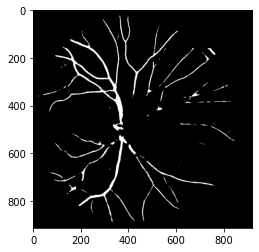

In [ ]:
plt.imshow(pred, cmap= 'gray')
plt.show()